#**1 Import**

In [ ]:
#Import generali
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import shutil
import cv2
import numpy as np
import tensorflow as tf
import joblib
from tqdm import tqdm
import seaborn as sns

In [ ]:
#Import usati per l'estrazione di features
!pip install tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

In [ ]:
#Import usati per la data augmentation
!pip install ipyplot
#!pip install imgaug
import ipyplot
import imageio
#import imgaug as ia
#import imgaug.augmenters as iaa
from PIL import Image
import PIL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00

        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
#Import usato per OpenCV
!pip install opencv-python
!pip install opencv-python-headless
import cv2


In [ ]:
#Controllo della versione installata
print(cv2.__version__)

4.11.0


In [ ]:
#Monto il contenuto di google drive su colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2 Costruzione dataset**

In [ ]:
#Carichiamo il file 'users.txt' che contiene i dati sul paziente che ha effettuato la visita
#Ogni riga rappresenta un paziente, che è caratterizzato da un id, un campo diag che ci dice se il paziente è disgrafico o meno, il sesso,
#la mano con cui scrive e l'età

users = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/utenti/users.txt', sep = '\t', dtype = str)

#la variabile users è di tipo dataframe
users

,ID,diag,sex,hand,age
0,00006,DYSGR,F,R,15
1,00007,DYSGR,M,R,15
2,00008,DYSGR,M,R,14
3,00011,DYSGR,M,R,8
4,00013,DYSGR,M,R,14
...,...,...,...,...,...
115,00187,0,M,R,15
116,00189,0,M,L,15
117,00190,0,F,R,15
118,00191,0,F,R,15


In [ ]:
#Creiamo una funzione chiamata 'Encoder' che seleziona una per una le colonne specificate e trasforma i suoi valori in valori numerici
def Encoder(users):
  le = LabelEncoder()
  users['diag'] = le.fit_transform(users.diag.values)
  users['sex'] = le.fit_transform(users.sex.values)
  users['hand'] = le.fit_transform(users.hand.values)
  return users

print(Encoder(users))

        ID  diag  sex  hand age
0    00006     1    0     0  15
1    00007     1    1     0  15
2    00008     1    1     0  14
3    00011     1    1     0   8
4    00013     1    1     0  14
..     ...   ...  ...   ...  ..
115  00187     0    1     0  15
116  00189     0    1     1  15
117  00190     0    0     0  15
118  00191     0    0     0  15
119  00192     0    1     0  15

[120 rows x 5 columns]


In [ ]:
print(users)

        ID  diag  sex  hand age
0    00006     1    0     0  15
1    00007     1    1     0  15
2    00008     1    1     0  14
3    00011     1    1     0   8
4    00013     1    1     0  14
..     ...   ...  ...   ...  ..
115  00187     0    1     0  15
116  00189     0    1     1  15
117  00190     0    0     0  15
118  00191     0    0     0  15
119  00192     0    1     0  15

[120 rows x 5 columns]


In [ ]:
#la variabile path serve per salvarmi il path per prendere i file delle sessioni dei pazienti
path='/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_preprocessed/user'

Modifica della cartella dataset_preprocessed. Abbiamo rinominato il file che ci serve ed eliminato le cartelle che non ci servono.

```

for row in range(120):
  user_id = str(users.iat[row, 0])
  shutil.move(path + user_id + '/session00001/u' + user_id + 's00001_hw00001.svc', path + user_id + '/' + 'user' + user_id + '.svc')
  shutil.rmtree(path + user_id + '/session00001')

```



##2.1 Salvataggio di tutte le immagini convertite

In [ ]:
#Funzione che mi permette di caricare il file relativo al paziente (caratterizzato da una corrispondenza tra il suo id e la sessione)
#Il file contiene le coordinate x e y, che insieme al campo 'touch' indicano la posizione in cui l'utente ha scritto, e altre features

def get_Session(row):
  #Il metodo iat ci permette di specificare indice di riga e di colonna del valore che vogliamo estrarre
  #user_id contiene l'id del paziente che ci permette di accedere al suo file relativo
  user_id = users.iat[row, 0]

  session = pd.read_csv(path + user_id + '/user' + user_id + '.svc', sep = ' ', skiprows=1)

  #Nel file è presento un'ottava colonna caratterizzata da ' ' che dobbiamo considerare per poter aggiungere il nome alle colonne
  session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']

  #Con il metodo drop eliminiamo la colonna 'spazio'
  #Mettiamo inplace= True così modifichiamo direttamente il dataframe session senza doverlo riassegnare
  session.drop('spazio', axis = 1 , inplace = True)
  return session

In [ ]:
#Funzione che costruisce l'immagine graficandola
def view_image(session,ax = None):
  xlist=[]
  ylist=[]
  indice_elemento = 0

  for touch_value in session['touch']:
    if touch_value == 1:
      xlist.append(session['x'][indice_elemento])
      ylist.append(session['y'][indice_elemento])
    else:
      if ax != None:
        ax.plot(xlist,ylist,color='black',linewidth=1)
      else:
        plt.plot(xlist,ylist,color='black',linewidth=1)
      xlist = []
      ylist = []
    indice_elemento += 1

In [ ]:
#Funzione che salva le immagini nel drive
def save_image(row):
  user_id = users.iat[row, 0]
  plt.axis('off')
  plt.savefig('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset/user' + user_id)
  plt.close()


In [ ]:
#Ciclo che permette di visualizzare e salvare le immagini create
for row in range(120):
  view_image(get_Session(row))
  save_image(row)

##2.2 Rappresentazione dell'input con confronto tra paziente affetto da disgrafia e paziente non affetto da disgrafia

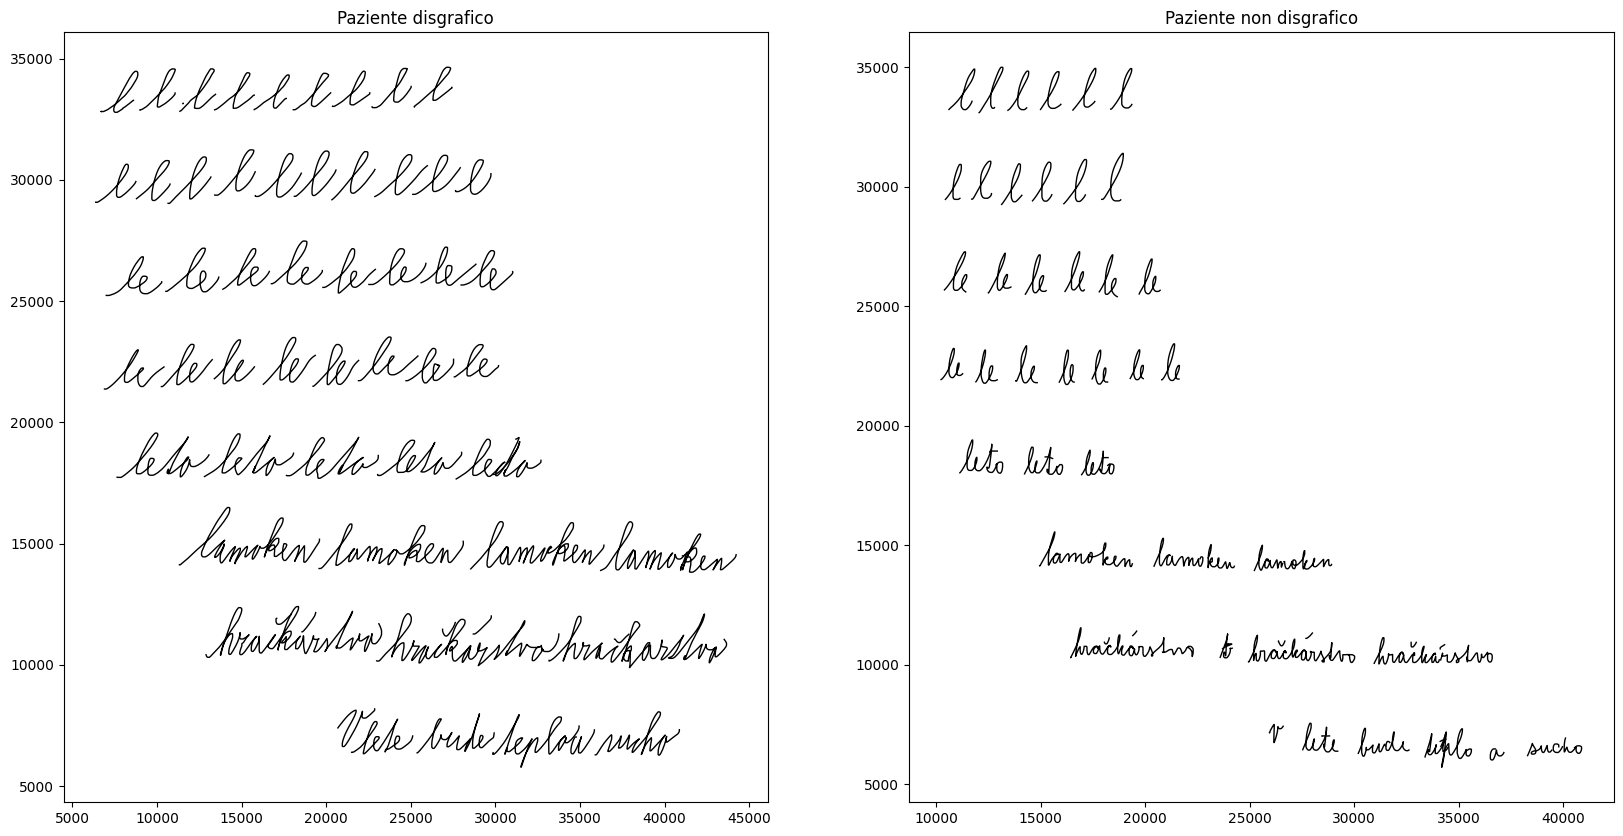

In [ ]:
user_disgrafico = get_Session(5)
user_no_disgrafico = get_Session(24)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))

ax1.set_title('Paziente disgrafico')
view_image(user_disgrafico,ax1)

ax2.set_title('Paziente non disgrafico')
view_image(user_no_disgrafico,ax2)

# **3 Estrazione delle features con CNN, VGG16 e ResNet50**

Vogliamo effettuare l'estrazione delle feature con ResNet50 e VGG16, per poi confrontare i risultati ottenuti

Entrambe le reti richiedono un'immagine a colori (3 canali). Tramite le seguenti righe di codice abbiamo verificato il numero di canali delle nostre immagini che è (288, 432, 3):



```
import cv2
img = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user00006.png')
img.shape
```

Voglio capire come appaiono le features estratte, pertanto definisco delle funzioni che caricano un'immagine e dopo averla data in input alla rete ritorna le features estratte

In [ ]:
def from_image_to_features(model):
  #cv2 restituisce un oggetto numpy
  image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset/user00006.png')

  #Dato che le reti ResNet50 e VGG16 accettano un input con shape (224,224,3), ridimensioniamo l'immagine
  img_reshaped = cv2.resize(image, (224, 224)).reshape(-1, 224, 224, 3)

  #Per soddisfare i requisiti di ResNet50/VGG16, l'immagine deve essere preprocessata
  img_reshaped = preprocess_input(img_reshaped)

  #Estraiamo le feature dall'immagine
  features = model.predict(img_reshaped)
  #Stampiamo la shape delle features ottenute dall'immagine
  return features

In [ ]:
def from_image_to_features2(model):
  #cv2 restituisce un oggetto numpy
  image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset/user00006.png')

  #Dato che le reti ResNet50 e VGG16 accettano un input con shape (299,299,3), ridimensioniamo l'immagine
  img_reshaped = cv2.resize(image, (299, 299)).reshape(1 , 299, 299, 3)

  #Per soddisfare i requisiti di ResNet50/VGG16, l'immagine deve essere preprocessata
  img_reshaped = preprocess_input(img_reshaped)

  #Estraiamo le feature dall'immagine
  features = model.predict(img_reshaped)
  #Stampiamo la shape delle features ottenute dall'immagine
  return features

Definisco delle funzioni che estraggono le features di tutto il dataset e le salva in un dataframe.

In [ ]:
def model_features_extraction(model):
  df = pd.DataFrame()

  for row in range(120) :
     user_id = str(users.iat[row, 0])
     image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset/user' + user_id + '.png')

     #Non effettuiamo la conversione dell'immagine in un array perché il metodo imread converte già l'immagine in un array
     #Effettuiamo il resize e il reshape dell'immagine perché ResNet50/VGG16 vuole un input shape pari a (1, 224, 224, 3)
     image = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)

     #Prepariamo l'immagine per la rete
     image = preprocess_input(image)

     #Estriamo le features
     features = model.predict(image)

      #Inseriamo le features di ogni immagine nel dataframe df1
     df1 = pd.DataFrame(features)

     #Concateniamo ogni df1 ottenuto a df
     df =  pd.concat([df, df1], ignore_index=True)

  return df

## 3.1 Estrazione delle features con ResNet50

In [ ]:
#Carichiamo la rete ResNet50 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelResNet50 = ResNet50()
modelResNet50 = Model(inputs=modelResNet50.inputs, outputs=modelResNet50.layers[-2].output)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#Vogliamo vedere la shape delle features estratte a partire da una singola immagine
featuresResNet50 = from_image_to_features(modelResNet50)
featuresResNet50.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(1, 2048)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfResNet50 = model_features_extraction(modelResNet50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 3.1.1 Rappresentazione delle features estratte da ResNet50

In [ ]:
#Al dataframe contenente tutte le features estratte aggiungiamo una colonna contenente le labels che ricaviamo dal file users
#Infine salviamo il dataframe ottenuto come file csv

dfResNet50['diag'] = users['diag']

dfResNet50.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionResNet50.csv')

In [ ]:
FeatureExtractionResNet50 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionResNet50.csv')

#Effettuiamo il drop della colonna 'Unnamed'
FeatureExtractionResNet50.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampiamo il file FeatureExtractionResNet50.csv ottenuto
FeatureExtractionResNet50

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,diag
0,0.182020,0.000000,0.009933,0.000000,0.025915,0.000000,0.000000,0.544486,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.074189,0.062921,0.613048,DYSGR
1,0.315346,0.009596,0.024514,0.005403,0.061587,0.027706,0.042724,0.662091,0.0,0.0,...,0.0,0.000000,0.001062,0.000000,0.0,0.0,0.010997,0.001982,0.815696,DYSGR
2,0.156178,0.000765,0.019915,0.000000,0.008179,0.089233,0.015469,0.492351,0.0,0.0,...,0.0,0.000000,0.000000,0.051539,0.0,0.0,0.003322,0.000000,0.847002,DYSGR
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002603,0.428543,0.0,0.0,...,0.0,0.000000,0.060862,0.000000,0.0,0.0,0.092932,0.138312,0.330373,DYSGR
4,0.022838,0.002973,0.176000,0.000000,0.033470,0.004917,0.009205,0.305316,0.0,0.0,...,0.0,0.006215,0.010632,0.000000,0.0,0.0,0.047379,0.054129,0.672329,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.256014,0.011078,0.000000,0.000000,0.097040,0.006900,0.056359,0.681882,0.0,0.0,...,0.0,0.000000,0.000000,0.001840,0.0,0.0,0.016204,0.021455,0.759780,0
116,0.059488,0.016943,0.000000,0.000000,0.000791,0.000000,0.012852,0.657451,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.045666,0.023281,0.570439,0
117,0.043501,0.007161,0.038941,0.000000,0.030174,0.000000,0.009831,0.467771,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.059679,0.028725,0.280297,0
118,0.012677,0.030957,0.004170,0.000000,0.004430,0.000000,0.000000,0.274937,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.104961,0.093263,0.408356,0


## 3.2 Estrazione delle features con VGG16

In [ ]:
#Carichiamo la rete VGG16 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelVGG16 = VGG16()
modelVGG16 = Model(inputs=modelVGG16.inputs, outputs=modelVGG16.layers[-2].output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [ ]:
#Vogliamo vedere la shape delle features estratte a partire da una singola immagine
featuresVGG16 = from_image_to_features(modelVGG16)
featuresVGG16.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


(1, 4096)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfVGG16 = model_features_extraction(modelVGG16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 3.2.1 Rappresentazione delle features estratte da VGG16

In [ ]:
#Al dataframe contenente tutte le features estratte aggiungiamo una colonna contenente le labels che ricaviamo dal file users
#Infine salviamo il dataframe ottenuto come file csv

dfVGG16['diag'] = users['diag']

dfVGG16.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionVGG16.csv')

In [ ]:
FeatureExtractionVGG16 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionVGG16.csv')

#Effettuiamo il drop della colonna 'Unnamed'. con inplace = True applichiamo la modifica alla variabile originale
FeatureExtractionVGG16.drop(["Unnamed: 0"], axis=1, inplace=True)
print(FeatureExtractionVGG16._get_value(0,'2054'))
#Stampiamo il file FeatureExtractionVGG16.csv ottenuto
FeatureExtractionVGG16

0.0


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,diag
0,0.0,0.158191,0.927538,0.000000,0.0,0.0,1.008125,0.0,0.0,0.0,...,0.0,0.371441,2.289002,0.0,0.0,0.268064,0.0,0.0,0.913801,DYSGR
1,0.0,0.341655,1.008132,0.000000,0.0,0.0,1.344761,0.0,0.0,0.0,...,0.0,0.237355,2.457631,0.0,0.0,0.783625,0.0,0.0,1.087506,DYSGR
2,0.0,0.000000,1.719300,0.096541,0.0,0.0,2.204869,0.0,0.0,0.0,...,0.0,0.934351,2.205162,0.0,0.0,0.830642,0.0,0.0,0.072449,DYSGR
3,0.0,0.000000,1.197505,0.000000,0.0,0.0,0.269102,0.0,0.0,0.0,...,0.0,0.181536,1.346474,0.0,0.0,0.000000,0.0,0.0,1.804727,DYSGR
4,0.0,0.000000,1.360226,0.000000,0.0,0.0,1.031211,0.0,0.0,0.0,...,0.0,0.980550,2.085102,0.0,0.0,0.000000,0.0,0.0,1.277890,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.000000,0.649893,0.000000,0.0,0.0,0.387099,0.0,0.0,0.0,...,0.0,0.000000,3.103955,0.0,0.0,0.000000,0.0,0.0,1.706239,0
116,0.0,0.000000,0.688619,0.000000,0.0,0.0,0.842569,0.0,0.0,0.0,...,0.0,0.346854,3.034117,0.0,0.0,0.000000,0.0,0.0,1.242995,0
117,0.0,0.241025,0.585466,0.000000,0.0,0.0,0.820543,0.0,0.0,0.0,...,0.0,0.511070,2.023446,0.0,0.0,0.000000,0.0,0.0,2.078225,0
118,0.0,0.212926,0.353205,0.000000,0.0,0.0,2.031229,0.0,0.0,0.0,...,0.0,0.903486,1.301465,0.0,0.0,0.201676,0.0,0.0,1.306508,0


#**4  OpenCV**

Vogliamo aggiungere le caratteristiche estratte con OpenCV alle caratteristiche CNN per migliorare la capacità del modello di riconoscere schemi rilevanti per la diagnosi della disgrafia, potenzialmente migliorando la precisione del sistema complessivo. Infatti la combinazione di tecniche tradizionali e deep learning permette di arricchire il set di dati e fornire maggiori informazioni per l'analisi.

##4.1 Estrazione delle features con OpenCV

Definisco una funzione che mi permetta di estrarre le caratteristiche dall'immagine usando OpenCV ( si prendono come riferimento contorni e istogrammi)

In [ ]:
# Funzione per l'estrazione delle features con OpenCV
def add_opencv_features(image):
    # Carica l'immagine in scala di grigi
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Estrazione dei contorni
    edges = cv2.Canny(gray_image, 100, 200)

    # Conta i contorni trovati
    num_edges = np.sum(edges) / 255

    # Estrazione di ulteriori caratteristiche (Istogrammi)
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist.flatten()

    # Combina le caratteristiche
    features_opencv = np.concatenate((hist, [num_edges]))

    return features_opencv

Estraggo le features con OpenCV salvando il tutto in un DataFrame

In [ ]:
# Inizializzo un DataFrame vuoto per memorizzare le caratteristiche
df_opencv = pd.DataFrame()

# Itero sulle immagini e estrai le caratteristiche
for row in range(120):
    user_id = str(users.iat[row, 0])
    image_path = '/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset/user' + user_id + '.png'
    image = cv2.imread(image_path)

    # Estraggo le caratteristiche OpenCV
    features = add_opencv_features(image)

    # Creo un DataFrame temporaneo per le caratteristiche dell'immagine corrente
    temp_df = pd.DataFrame(features.reshape(1, -1))

    # Aggiungo le caratteristiche al DataFrame principale
    df_opencv = pd.concat([df_opencv, temp_df], ignore_index=True)

# Aggiungo le etichette al DataFrame
df_opencv['diag'] = users['diag']

# Salvo il DataFrame in un file CSV
df_opencv.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionOpenCV.csv')

Rappresentazione delle features estratte con OpenCV

In [ ]:
FeatureExtractionOpenCV = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionOpenCV.csv')

#Effettuo il drop della colonna 'Unnamed'
FeatureExtractionOpenCV.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampo il file FeatureExtractionOpenCV.csv ottenuto
FeatureExtractionOpenCV

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,diag
0,2860.0,103.0,91.0,70.0,66.0,69.0,63.0,54.0,60.0,56.0,...,69.0,82.0,111.0,80.0,121.0,160.0,321.0,295316.0,6845.0,DYSGR
1,2349.0,87.0,73.0,78.0,65.0,57.0,38.0,47.0,39.0,37.0,...,71.0,67.0,70.0,98.0,116.0,125.0,268.0,297514.0,5693.0,DYSGR
2,2097.0,98.0,60.0,65.0,55.0,49.0,47.0,47.0,49.0,52.0,...,68.0,62.0,68.0,99.0,98.0,125.0,303.0,297398.0,6029.0,DYSGR
3,2820.0,148.0,107.0,104.0,75.0,83.0,84.0,82.0,78.0,66.0,...,95.0,91.0,127.0,114.0,141.0,162.0,394.0,292298.0,9378.0,DYSGR
4,1786.0,96.0,84.0,76.0,60.0,72.0,49.0,43.0,59.0,53.0,...,64.0,75.0,79.0,105.0,107.0,124.0,292.0,297342.0,6205.0,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2257.0,86.0,65.0,75.0,72.0,59.0,51.0,47.0,49.0,48.0,...,60.0,59.0,79.0,88.0,95.0,125.0,325.0,296789.0,6483.0,0
116,1527.0,61.0,55.0,51.0,47.0,46.0,39.0,29.0,37.0,24.0,...,35.0,50.0,49.0,66.0,65.0,93.0,227.0,299627.0,4662.0,0
117,1526.0,61.0,30.0,47.0,26.0,31.0,30.0,24.0,34.0,29.0,...,36.0,37.0,40.0,52.0,58.0,92.0,149.0,300551.0,3859.0,0
118,2039.0,58.0,32.0,48.0,36.0,34.0,38.0,35.0,31.0,28.0,...,54.0,40.0,48.0,67.0,83.0,73.0,203.0,299404.0,4717.0,0


##4.1 Estrazione delle features con ResNet50, VGG16 e OpenCV

In [ ]:
# Carico i DataFrame delle features
FeatureExtractionResNet50 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionResNet50.csv')
FeatureExtractionVGG16 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionVGG16.csv')
FeatureExtractionOpenCV = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionOpenCV.csv')


###4.1.1 Combinazione delle features in un unico DataFrame

In [ ]:
# Unisco i DataFrame
merged_features = pd.concat([FeatureExtractionResNet50, FeatureExtractionVGG16, FeatureExtractionOpenCV.drop('diag', axis=1)], axis=1)

# Salvo il DataFrame combinato
merged_features.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionCombined.csv')

Rappresentazione delle features combinate

In [ ]:
FeatureExtractionCombined = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionCombined.csv')

#Effettuo il drop della colonna 'Unnamed'
FeatureExtractionCombined.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampo il file FeatureExtractionCombined.csv ottenuto
FeatureExtractionCombined

,Unnamed: 0.3,0,1,2,3,4,5,6,7,8,...,247.2,248.2,249.2,250.2,251.2,252.2,253.2,254.2,255.2,256.2
0,0,0.182020,0.000000,0.009933,0.000000,0.025915,0.000000,0.000000,0.544486,0.0,...,71.0,69.0,82.0,111.0,80.0,121.0,160.0,321.0,295316.0,6845.0
1,1,0.315346,0.009596,0.024514,0.005403,0.061587,0.027706,0.042724,0.662091,0.0,...,50.0,71.0,67.0,70.0,98.0,116.0,125.0,268.0,297514.0,5693.0
2,2,0.156178,0.000765,0.019915,0.000000,0.008179,0.089233,0.015469,0.492351,0.0,...,60.0,68.0,62.0,68.0,99.0,98.0,125.0,303.0,297398.0,6029.0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002603,0.428543,0.0,...,90.0,95.0,91.0,127.0,114.0,141.0,162.0,394.0,292298.0,9378.0
4,4,0.022838,0.002973,0.176000,0.000000,0.033470,0.004917,0.009205,0.305316,0.0,...,77.0,64.0,75.0,79.0,105.0,107.0,124.0,292.0,297342.0,6205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,0.256014,0.011078,0.000000,0.000000,0.097040,0.006900,0.056359,0.681882,0.0,...,51.0,60.0,59.0,79.0,88.0,95.0,125.0,325.0,296789.0,6483.0
116,116,0.059488,0.016943,0.000000,0.000000,0.000791,0.000000,0.012852,0.657451,0.0,...,53.0,35.0,50.0,49.0,66.0,65.0,93.0,227.0,299627.0,4662.0
117,117,0.043501,0.007161,0.038941,0.000000,0.030174,0.000000,0.009831,0.467771,0.0,...,48.0,36.0,37.0,40.0,52.0,58.0,92.0,149.0,300551.0,3859.0
118,118,0.012677,0.030957,0.004170,0.000000,0.004430,0.000000,0.000000,0.274937,0.0,...,48.0,54.0,40.0,48.0,67.0,83.0,73.0,203.0,299404.0,4717.0


#**5 Estrazione delle features con CNN, DenseNet121**

Si vuole estrarre caratteristiche dal dataset utilizzando un'altra architettura di rete neurale convoluzionale (CNN). DenseNet è una buona scelta perché è una rete profonda che sfrutta connessioni dense, permettendo a ogni livello di ricevere input da tutti i livelli precedenti, migliorando la propagazione delle informazioni e il gradiente.

##5.1 Estrazione delle features con DenseNet121

In [ ]:
#Carico la rete DenseNet121 preaddestrata da cui tolgo l'ultimo layer che serve per la classificazione (mi sono basati su model.summary())
modelDenseNet121 = DenseNet121()
modelDenseNet121 = Model(inputs=modelDenseNet121.inputs, outputs=modelDenseNet121.layers[-2].output)

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Voglio vedere la shape delle features estratte a partire da una singola immagine
featuresDenseNet121 = from_image_to_features(modelDenseNet121)
featuresDenseNet121.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


(1, 1024)

In [ ]:
#Effettuo l'estrazione delle features di tutto il dataset
dfDenseNet121 = model_features_extraction(modelDenseNet121)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

###5.1.1 Rappresentazione delle features estratte da DenseNet121

In [ ]:
#Al dataframe contenente tutte le features estratte aggiungo una colonna contenente le labels che ricaviamo dal file users
#Infine salviamo il dataframe ottenuto come file csv

dfDenseNet121['diag'] = users['diag']

dfDenseNet121.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDenseNet121.csv')

In [ ]:
FeatureExtractionDenseNet121 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDenseNet121.csv')

#Effettuo il drop della colonna 'Unnamed'. con inplace = True applichiamo la modifica alla variabile originale
FeatureExtractionDenseNet121.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampo il file FeatureExtractionDenseNet121.csv ottenuto
FeatureExtractionDenseNet121

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,diag
0,0.0,0.002449,0.007695,0.003601,0.076305,0.000000,0.001387,0.005928,0.000000,0.003884,...,19.170984,0.128124,0.000000,12.974366,11.369502,0.144210,19.642223,5.339010,13.812140,DYSGR
1,0.0,0.000113,0.007518,0.000868,0.174762,0.000000,0.001081,0.006632,0.045615,0.002868,...,14.566050,0.116951,0.008236,13.709644,12.873471,0.278213,22.190783,3.601805,7.429430,DYSGR
2,0.0,0.000794,0.008192,0.001621,0.130074,0.000000,0.001500,0.006497,0.000000,0.002520,...,20.491755,0.218464,0.003059,8.067709,11.642061,0.930948,13.216947,6.323649,10.563113,DYSGR
3,0.0,0.015630,0.012116,0.001700,0.103523,0.000000,0.002158,0.011278,0.041508,0.003050,...,9.626988,0.205928,0.138428,14.893395,6.547496,0.297324,16.206001,6.202311,10.645516,DYSGR
4,0.0,0.000395,0.011313,0.000001,0.118854,0.000000,0.000536,0.010069,0.037155,0.003315,...,10.015572,0.053611,0.059756,12.882584,8.137750,0.158297,15.133362,3.865012,9.132915,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.000985,0.011517,0.001839,0.165891,0.000000,0.000972,0.009319,0.090742,0.003857,...,16.573643,0.057285,0.000000,10.798043,12.346595,0.000000,19.387548,3.617747,5.227393,0
116,0.0,0.000000,0.012516,0.000000,0.129333,0.064300,0.000566,0.007699,0.074015,0.004108,...,11.591753,0.095444,0.000253,10.281158,10.743600,0.007353,13.715281,5.697630,9.521830,0
117,0.0,0.000000,0.010646,0.000022,0.108635,0.022311,0.000331,0.007861,0.011411,0.003440,...,5.432525,0.126090,0.029469,11.419520,8.873359,0.000000,9.268262,5.662700,9.284002,0
118,0.0,0.000000,0.009191,0.000071,0.130786,0.000000,0.000421,0.004743,0.000000,0.002622,...,10.798881,0.195663,0.000000,12.950341,11.948094,0.000000,13.051237,7.992834,16.996437,0


##5.2 Combinazione di tutte le features

In [ ]:
# Carico i DataFrame delle features
FeatureExtractionResNet50 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionResNet50.csv')
FeatureExtractionVGG16 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionVGG16.csv')
FeatureExtractionOpenCV = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionOpenCV.csv')
FeatureExtractionDenseNet121 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDenseNet121.csv')

# Unisco i DataFrame
all_merged_features = pd.concat([FeatureExtractionResNet50, FeatureExtractionVGG16, FeatureExtractionOpenCV.drop('diag', axis=1), FeatureExtractionDenseNet121.drop('diag', axis=1)], axis=1)

# Salvo il DataFrame combinato
all_merged_features.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/AllFeatureExtractionCombined.csv')


Rappresentazione delle features combinate

In [ ]:
AllFeatureExtractionCombined = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/AllFeatureExtractionCombined.csv')

#Stampo il file AllFeatureExtractionCombined.csv ottenuto
AllFeatureExtractionCombined

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1014.2,1015.2,1016.2,1017.2,1018.2,1019.2,1020.2,1021.2,1022.2,1023.2
0,0,0.182020,0.000000,0.009933,0.000000,0.025915,0.000000,0.000000,0.544486,0.0,...,1.510478,19.170984,0.128124,0.000000,12.974366,11.369502,0.144210,19.642223,5.339010,13.812140
1,1,0.315346,0.009596,0.024514,0.005403,0.061587,0.027706,0.042724,0.662091,0.0,...,1.624474,14.566050,0.116951,0.008236,13.709644,12.873471,0.278213,22.190783,3.601805,7.429430
2,2,0.156178,0.000765,0.019915,0.000000,0.008179,0.089233,0.015469,0.492351,0.0,...,1.033713,20.491755,0.218464,0.003059,8.067709,11.642061,0.930948,13.216947,6.323649,10.563113
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002603,0.428543,0.0,...,2.296417,9.626988,0.205928,0.138428,14.893395,6.547496,0.297324,16.206001,6.202311,10.645516
4,4,0.022838,0.002973,0.176000,0.000000,0.033470,0.004917,0.009205,0.305316,0.0,...,1.537361,10.015572,0.053611,0.059756,12.882584,8.137750,0.158297,15.133362,3.865012,9.132915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,0.256014,0.011078,0.000000,0.000000,0.097040,0.006900,0.056359,0.681882,0.0,...,0.486099,16.573643,0.057285,0.000000,10.798043,12.346595,0.000000,19.387548,3.617747,5.227393
116,116,0.059488,0.016943,0.000000,0.000000,0.000791,0.000000,0.012852,0.657451,0.0,...,0.439122,11.591753,0.095444,0.000253,10.281158,10.743600,0.007353,13.715281,5.697630,9.521830
117,117,0.043501,0.007161,0.038941,0.000000,0.030174,0.000000,0.009831,0.467771,0.0,...,0.935725,5.432525,0.126090,0.029469,11.419520,8.873359,0.000000,9.268262,5.662700,9.284002
118,118,0.012677,0.030957,0.004170,0.000000,0.004430,0.000000,0.000000,0.274937,0.0,...,0.849615,10.798881,0.195663,0.000000,12.950341,11.948094,0.000000,13.051237,7.992834,16.996437


# **6 Estrazione delle features con CNN, InceptionV3**

InceptionV3 introduce il concetto di moduli Inception, che permettono di combinare filtri di diverse dimensioni per estrarre feature a diverse scale.

##6.1 Estrazione delle features con InceptionV3

In [ ]:
#Carico la rete InceptionV3 preaddestrata da cui tolgo l'ultimo layer che serve per la classificazione (mi sono basati su model.summary())
modelInceptionV3 = InceptionV3()
modelInceptionV3 = Model(inputs=modelInceptionV3.inputs, outputs=modelInceptionV3.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#Voglio vedere la shape delle features estratte a partire da una singola immagine
featuresInceptionV3 = from_image_to_features2(modelInceptionV3)
featuresInceptionV3.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(1, 2048)

In [ ]:
#Effettuo l'estrazione delle features di tutto il dataset
dfInceptionV3 = model_features_extraction(modelInceptionV3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

###6.1.1 Rappresentazione delle features estratte da InceptionV3

In [ ]:
#Al dataframe contenente tutte le features estratte aggiungo una colonna contenente le labels che ricaviamo dal file users
#Infine salviamo il dataframe ottenuto come file csv

dfInceptionV3['diag'] = users['diag']

dfInceptionV3.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionInceptionV3.csv')

In [ ]:
FeatureExtractionInceptionV3 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionInceptionV3.csv')

#Effettuo il drop della colonna 'Unnamed'. con inplace = True applichiamo la modifica alla variabile originale
FeatureExtractionInceptionV3.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampo il file FeatureExtractionInceptionV3.csv ottenuto
FeatureExtractionInceptionV3

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,diag
0,0.0,0.113407,2.435917,17.933918,3.874208,5.756312,3.872680,23.129707,0.000000,34.688160,...,0.261135,0.000123,2.500067,25.743890,31.142345,8.808096,0.000000,0.000000,0.239031,DYSGR
1,0.0,0.379726,4.834220,18.914322,2.493407,4.309935,4.995348,19.946077,0.000000,36.420628,...,0.000000,0.044963,4.351594,29.736122,19.505290,11.387099,0.010328,0.000000,0.000000,DYSGR
2,0.0,0.125731,5.166103,24.370262,3.033886,4.032946,7.629916,23.238710,0.005861,26.188719,...,0.000000,0.000000,7.056505,17.345114,22.866177,1.173245,0.000000,0.185311,0.203411,DYSGR
3,0.0,0.085799,1.977781,23.836530,2.437421,3.165162,4.602505,17.188555,0.000000,30.438477,...,0.142940,0.000000,3.763365,15.460176,49.328724,9.636018,0.000000,1.806614,2.100774,DYSGR
4,0.0,1.266979,4.833531,25.139381,1.670212,6.099101,6.759100,16.313604,0.231872,36.313736,...,0.000000,0.078904,7.781083,24.596657,22.396873,4.919441,0.099888,0.033288,0.000000,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.063115,2.043839,12.984531,2.960737,4.955175,4.174210,13.616158,0.000000,35.201570,...,0.000000,0.000000,3.475207,22.036064,30.192808,11.254735,1.326876,1.825686,0.804298,0
116,0.0,1.946357,7.061615,32.408253,4.902230,5.087683,5.617695,29.095642,0.365373,39.798187,...,0.000000,0.741976,2.426854,10.479889,11.580742,13.403803,0.000000,0.000000,0.000000,0
117,0.0,3.708812,1.697179,35.860775,6.971398,5.939732,6.233107,34.920185,0.358528,42.440784,...,0.229464,3.213812,0.496879,4.095715,10.035898,23.729542,0.000000,0.000000,0.000000,0
118,0.0,2.259499,2.700476,33.327652,2.386013,3.385547,10.946212,15.466537,0.304292,29.311277,...,0.000000,0.000000,5.041525,25.740189,7.452128,12.074951,0.000000,0.000000,0.000000,0


##6.2 Combinazione di tutte le features

In [ ]:
# Carico i DataFrame delle features
FeatureExtractionResNet50 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionResNet50.csv')
FeatureExtractionVGG16 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionVGG16.csv')
FeatureExtractionOpenCV = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionOpenCV.csv')
FeatureExtractionDenseNet121 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDenseNet121.csv')
FeatureExtractionInceptionv3 = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionInceptionV3.csv')

# Rimuovo le colonne non necessarie
FeatureExtractionResNet50.drop(["Unnamed: 0"], axis=1, inplace=True)
FeatureExtractionVGG16.drop(["Unnamed: 0"], axis=1, inplace=True)
FeatureExtractionOpenCV.drop(["Unnamed: 0"], axis=1, inplace=True)
FeatureExtractionDenseNet121.drop(["Unnamed: 0"], axis=1, inplace=True)

# Unisco i DataFrame
all_merged_features = pd.concat([FeatureExtractionResNet50, FeatureExtractionVGG16, FeatureExtractionOpenCV.drop('diag', axis=1), FeatureExtractionDenseNet121.drop('diag', axis=1), FeatureExtractionInceptionV3.drop('diag', axis=1)], axis=1)

# Salvo il DataFrame combinato
all_merged_features.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/AllFeatureExtractionCombined2.csv')


#**7 Applicazione della Data Augmentation al dataset originale**

Vogliamo aumentare il numero di istanze del nostro dataset per ridurre l'overfitting riscontrato nella classificazione applicata al dataset originale. Pertanto, modifichiamo il nostro dataset originale applicando diverse strategie di data augmentation: image cropping (zoom su una sezione dell'immagine), add of gaussian noise (sporchiamo l'immagine)

##7.3 Image Cropping

In [ ]:
def image_cropping(image):
  crop1 = iaa.Crop(percent=(0, 0.3))
  input_crop1 = crop1.augment_image(image)
  return input_crop1

###7.3.1 Rappresentazione della tecnica utilizzata su una singola immagine


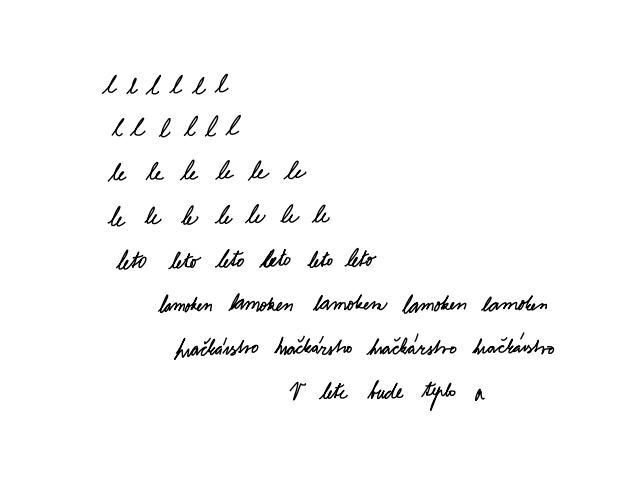
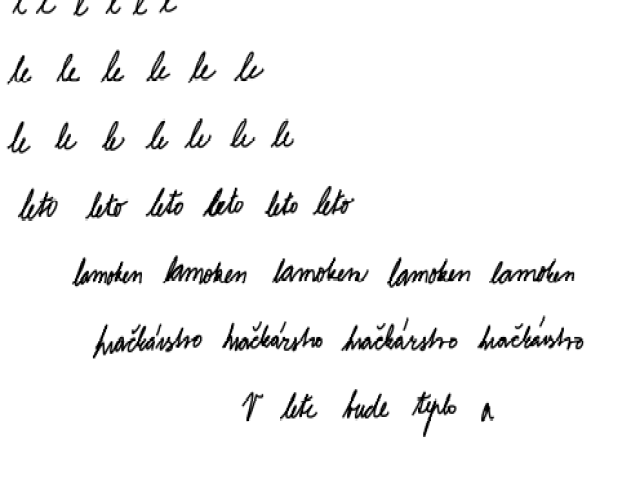


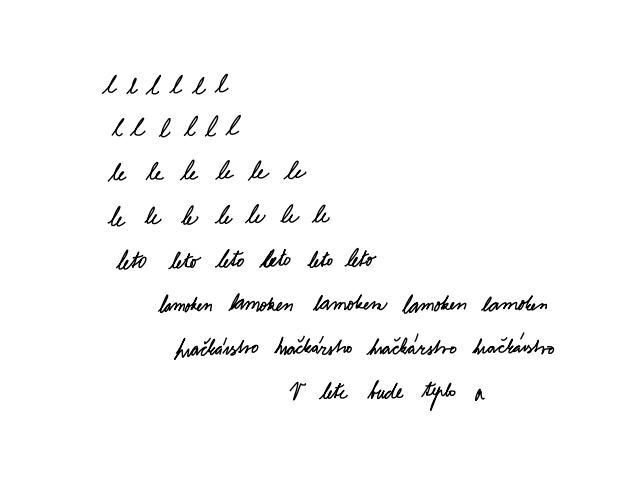
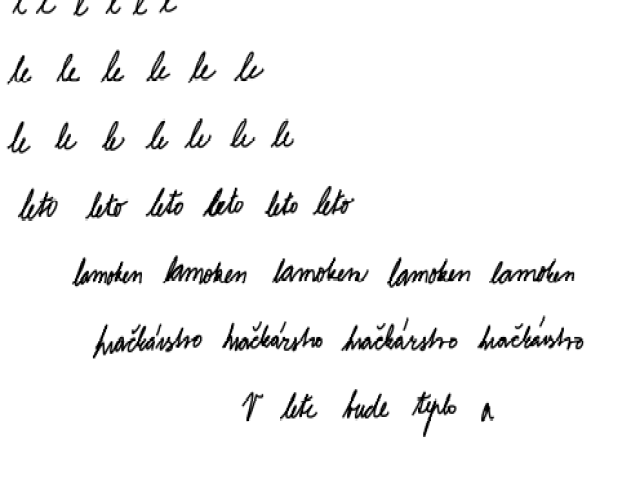

In [ ]:
image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset/user00006.png')
input_crop1 = image_cropping(image)
images_list = [image,input_crop1]
labels = ['Original', 'Cropped image']
ipyplot.plot_images(images_list,labels=labels,img_width=500)

###7.3.2 Salvataggio delle immagini modificate

In [ ]:
for i in range(120):
  user_id = str(users.iat[i, 0])
  image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_augmentation/dataset_originale/user' + user_id + '.png')
  input_crop1 = image_cropping(image)
  input_crop1 = Image.fromarray(input_crop1, 'RGB')
  input_crop1.save('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_augmentation/dataset_cropped/user' + user_id + '.png')

## 7.4 Aggiungiamo rumore gaussiano alle immagini

In [ ]:
def noise(image):
  noise=iaa.AdditiveGaussianNoise(10,40)
  input_noise=noise.augment_image(image)
  return input_noise

###7.4.1 Rappresentazione della tecnica utilizzata su una singola immagine


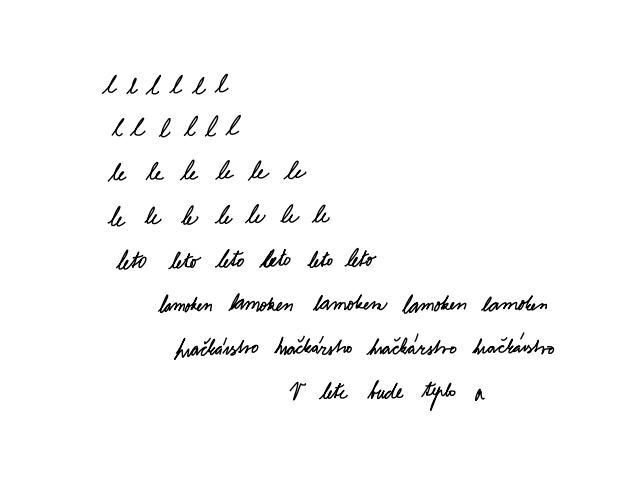
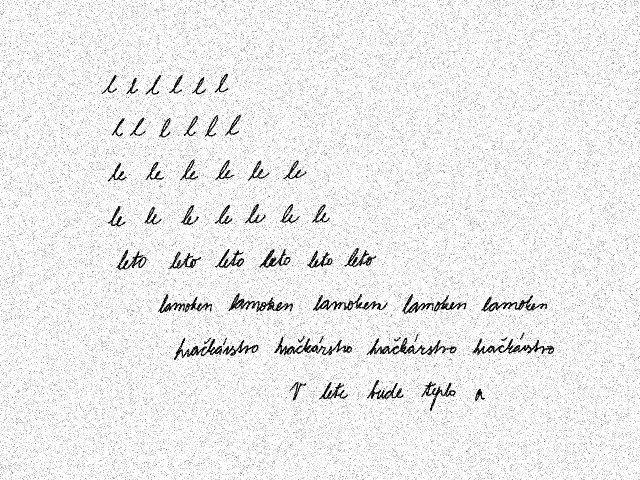


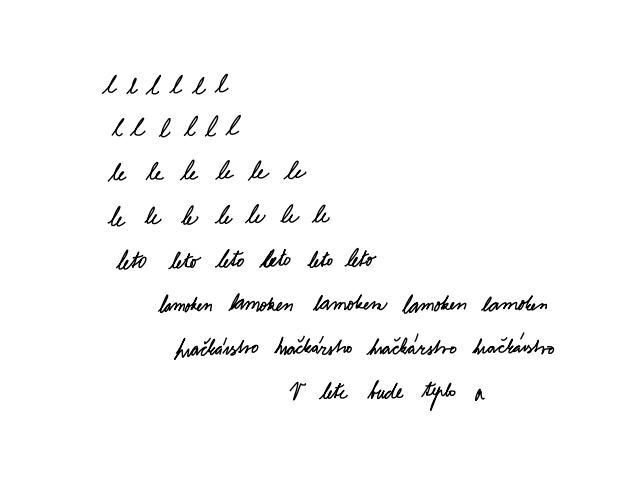
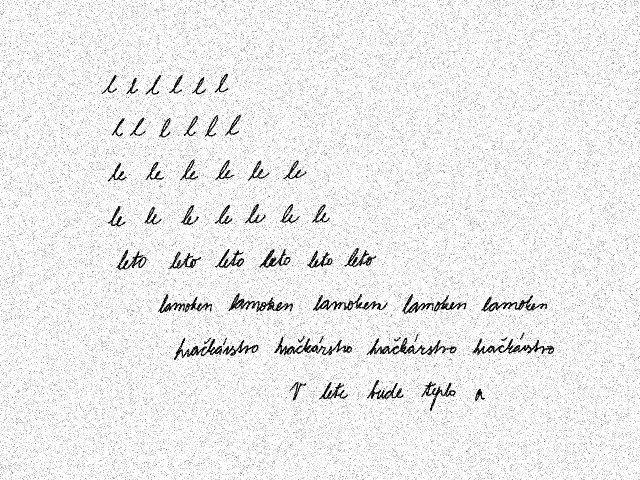

In [ ]:
image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset/user00006.png')
input_noise = noise(image)
images_list = [image,input_noise]
labels = ['Original', 'Gaussian Noise Image']
ipyplot.plot_images(images_list,labels=labels,img_width=500)

###7.4.2 Salvataggio delle immagini modificate

In [ ]:
for i in range(120):
  user_id = str(users.iat[i, 0])
  image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_augmentation/dataset_originale/user' + user_id + '.png')
  input_noise = noise(image)
  input_noise = Image.fromarray(input_noise, 'RGB')
  input_noise.save('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_augmentation/dataset_noise/user' + user_id + '.png')

#**8 Estrazione features con Data Augmentation**


In [ ]:
def model_features_extraction_dataAug(model):
  df = pd.DataFrame()
  list_dataset= ['cropped', 'noise', 'originale']
  for row in range(120) :
     user_id = str(users.iat[row, 0])
     for dataset in list_dataset:
       image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_augmentation/dataset_'+ dataset +'/user' + user_id + '.png')

       #Non effettuiamo la conversione dell'immagine in un array perché il metodo imread converte già l'immagine in un array
       #Effettuiamo il resize e il reshape dell'immagine perché ResNet50/VGG16 vuole un input shape pari a (1, 224, 224, 3)
       image = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)

       #Prepariamo l'immagine per la rete
       image = preprocess_input(image)

       #Estriamo le features
       features = model.predict(image)

       #Inseriamo le features di ogni immagine nel dataframe df1
       df1 = pd.DataFrame(features)

       #Concateniamo ogni df1 ottenuto a df
       df =  pd.concat([df, df1], ignore_index=True)

  return df

In [ ]:
def model_features_extraction_dataAug2(model):
  df = pd.DataFrame()
  list_dataset= ['cropped', 'noise', 'originale']
  for row in range(120) :
     user_id = str(users.iat[row, 0])
     for dataset in list_dataset:
       image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_augmentation/dataset_'+ dataset +'/user' + user_id + '.png')

       #Ridimensiono prima l'immagine a (299, 299)
       #Non effettuiamo la conversione dell'immagine in un array perché il metodo imread converte già l'immagine in un array
       #Effettuiamo il resize e il reshape dell'immagine perché ResNet50/VGG16 vuole un input shape pari a (1, 224, 224, 3)
       image = cv2.resize(image, (299, 299)).reshape(1, 299, 299, 3)

       #Prepariamo l'immagine per la rete
       image = preprocess_input(image)

       #Estriamo le features
       features = model.predict(image)

       #Inseriamo le features di ogni immagine nel dataframe df1
       df1 = pd.DataFrame(features)

       #Concateniamo ogni df1 ottenuto a df
       df =  pd.concat([df, df1], ignore_index=True)

  return df

In [ ]:
#Al dataframe contenente tutte le features estratte dovremo aggiungere una colonna contenente le labels.
#Per fare ciò, prima di tutto costruiamo un dataframe contenente tutte le labels associate alle 720 righe del nuovo datatset ottenuto applicando la data augmentation.
#Per come abbiamo costruito il dataset ogni gruppo di 6 righe è associato allo stesso user.
#Pertanto, le prime 6 righe sono associate allo user00006, le seconde 6 righe sono associate allo user00007,......., le ultime 6 righe sono associate allo user00192

list_value = []
for row in range(120):
  user_id = str(users.iat[row, 0])
  cont = 0
  while cont !=3 :
    list_value.append(users['diag'][row])
    cont = cont + 1

df_diag = pd.DataFrame({'diag' : list_value})

##8.1 Estrazione delle features con ResNet50

In [ ]:
#Carichiamo la rete ResNet50 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelResNet50_aug = ResNet50()
modelResNet50_aug = Model(inputs=modelResNet50_aug.inputs, outputs=modelResNet50_aug.layers[-2].output)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfResNet50_aug = model_features_extraction_dataAug(modelResNet50_aug)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

### 7.1.1 Rappresentazione delle features estratte da ResNet50

In [ ]:
#Associamo il dataframe df_diag contenente le labels al dataframe contenente le feature estratte dalla rete
dfResNet50_aug['diag'] = df_diag['diag']

In [ ]:
#Infine salviamo il dataframe ottenuto come file csv
dfResNet50_aug.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationResNet50.csv')

In [ ]:
FeatureExtractionResNet50_aug = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationResNet50.csv')

#Effettuiamo il drop della colonna 'Unnamed'
FeatureExtractionResNet50_aug.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampiamo il file FeatureExtractionResNet50.csv ottenuto
FeatureExtractionResNet50_aug

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,diag
0,0.000000,0.010110,0.031813,0.0,0.050464,0.000000,0.006248,0.121825,0.0,0.000000,...,0.000000,0.009580,0.000000,0.000000,0.000000,0.0,0.020557,0.000039,0.323079,DYSGR
1,0.088682,0.107630,0.076160,0.0,0.034523,0.017523,0.108511,0.593886,0.0,0.000000,...,0.013885,0.016886,0.000000,0.058122,0.035244,0.0,0.057671,0.000000,0.757402,DYSGR
2,0.035744,0.000000,0.009859,0.0,0.138623,0.003192,0.000000,0.404215,0.0,0.000000,...,0.000000,0.000000,0.000431,0.000000,0.000000,0.0,0.092356,0.147713,0.694410,DYSGR
3,0.000000,0.078063,0.000000,0.0,0.186519,0.000000,0.018772,0.119470,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.019637,0.026698,0.419112,DYSGR
4,0.157913,0.134153,0.052550,0.0,0.038611,0.029195,0.135405,0.454571,0.0,0.000000,...,0.016797,0.042287,0.000000,0.000000,0.056996,0.0,0.099616,0.000000,0.759641,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.228027,0.127003,0.036322,0.0,0.012727,0.006084,0.001775,0.000000,0.0,0.000122,...,0.033053,0.000000,0.000000,0.000000,0.000000,0.0,0.065118,0.000000,0.186907,0
356,0.009474,0.010007,0.000000,0.0,0.019085,0.000000,0.000000,0.402218,0.0,0.000000,...,0.000000,0.001006,0.000000,0.000000,0.000000,0.0,0.109892,0.162073,0.365336,0
357,0.000000,0.058281,0.000000,0.0,0.037524,0.000000,0.000000,0.073414,0.0,0.000000,...,0.000000,0.000000,0.000000,0.012358,0.000000,0.0,0.116960,0.035159,0.152908,0
358,0.252511,0.185512,0.363863,0.0,0.074617,0.022708,0.014958,0.621345,0.0,0.011937,...,0.091861,0.086587,0.000000,0.000000,0.195190,0.0,0.041041,0.000000,0.797083,0


##8.2 Estrazione delle features con VGG16

In [ ]:
#Carichiamo la rete VGG16 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelVGG16_aug = VGG16()
modelVGG16_aug = Model(inputs=modelVGG16_aug.inputs, outputs=modelVGG16_aug.layers[-2].output)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfVGG16_aug = model_features_extraction_dataAug(modelVGG16_aug)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

###8.2.1 Rappresentazione delle features estratte da VGG16

In [ ]:
#Associamo il dataframe df_diag contenente le labels al dataframe contenente le feature estratte dalla rete
#Infine salviamo il dataframe ottenuto come file csv

dfVGG16_aug['diag'] = df_diag['diag']

dfVGG16_aug.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationVGG16.csv')

In [ ]:
FeatureExtractionVGG16_aug = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationVGG16.csv')

#Effettuiamo il drop della colonna 'Unnamed'. con inplace = True applichiamo la modifica alla variabile originale
FeatureExtractionVGG16_aug.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampiamo il file FeatureExtractionVGG16.csv ottenuto
FeatureExtractionVGG16_aug

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,diag
0,0.0,0.000000,1.154130,0.000000,0.000000,0.0,0.991197,0.0,0.0,0.0,...,0.0,0.235206,1.825834,0.0,0.0,0.840937,0.0,0.000000,0.289122,1
1,0.0,0.000000,0.000000,0.000000,2.106285,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.670465,0.0,0.0,2.322833,0.0,1.762229,1.085200,1
2,0.0,0.192173,0.856219,0.000000,0.000000,0.0,0.753882,0.0,0.0,0.0,...,0.0,0.203728,1.984265,0.0,0.0,0.000000,0.0,0.000000,1.307775,1
3,0.0,0.000000,1.284008,0.000000,0.000000,0.0,0.800378,0.0,0.0,0.0,...,0.0,0.524613,2.961107,0.0,0.0,0.000000,0.0,0.000000,0.171719,1
4,0.0,0.668859,0.000000,0.118815,0.655026,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,2.961211,0.0,0.0,2.128743,0.0,1.989876,1.026604,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0,0.846486,0.000000,0.000000,2.238588,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.183757,0.0,0.0,0.000000,0.0,1.109783,0.435480,0
356,0.0,0.361304,0.322297,0.000000,0.000000,0.0,1.881393,0.0,0.0,0.0,...,0.0,0.901802,1.595292,0.0,0.0,0.252073,0.0,0.000000,1.165724,0
357,0.0,0.018513,2.114730,0.000000,0.000000,0.0,1.551536,0.0,0.0,0.0,...,0.0,1.128461,2.686169,0.0,0.0,0.457895,0.0,0.000000,0.308394,0
358,0.0,0.744105,0.060020,0.000000,0.898333,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.345604,3.432374,0.0,0.0,0.762361,0.0,1.577733,1.378852,0


##8.3 Estrazione delle features con OpenCV

In [ ]:
def model_features_extraction_dataAug_opencv():
  df = pd.DataFrame()
  list_dataset= ['cropped', 'noise', 'originale']
  for row in range(120) :
     user_id = str(users.iat[row, 0])
     for dataset in list_dataset:
       image = cv2.imread('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/dataset_augmentation/dataset_'+ dataset +'/user' + user_id + '.png')

       # Estraggo le caratteristiche OpenCV
       features = add_opencv_features(image)

       # Creo un DataFrame temporaneo per le caratteristiche dell'immagine corrente
       temp_df = pd.DataFrame(features.reshape(1, -1))

       # Aggiungo le caratteristiche al DataFrame principale
       df = pd.concat([df, temp_df], ignore_index=True)

  return df

# Effettuo l'estrazione delle features con OpenCV
dfOpenCV_aug = model_features_extraction_dataAug_opencv()

###8.3.1 Rappresentazione delle features estratte con OpenCV

In [ ]:
# Associo il dataframe df_diag contenente le labels al dataframe contenente le feature estratte dalla rete
dfOpenCV_aug['diag'] = df_diag['diag']

# Infine salvo il dataframe ottenuto come file csv
dfOpenCV_aug.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationOpenCV.csv')

In [ ]:
FeatureExtractionOpenCV_aug = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationOpenCV.csv')

# Effettuo il drop della colonna 'Unnamed'
FeatureExtractionOpenCV_aug.drop(["Unnamed: 0"], axis=1, inplace=True)

# Stampo il file FeatureExtractionOpenCV.csv ottenuto
FeatureExtractionOpenCV_aug

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,diag
0,567.0,54.0,45.0,32.0,43.0,47.0,46.0,40.0,35.0,35.0,...,140.0,126.0,178.0,186.0,224.0,274.0,479.0,110801.0,5597.0,DYSGR
1,631.0,10.0,19.0,19.0,14.0,19.0,10.0,23.0,18.0,19.0,...,1151.0,1083.0,1153.0,1145.0,1126.0,1199.0,1185.0,72128.0,29284.0,DYSGR
2,1092.0,11.0,13.0,10.0,16.0,11.0,11.0,13.0,10.0,12.0,...,41.0,52.0,56.0,52.0,63.0,104.0,184.0,118445.0,3578.0,DYSGR
3,306.0,50.0,34.0,42.0,24.0,34.0,27.0,42.0,29.0,49.0,...,104.0,124.0,144.0,133.0,175.0,266.0,423.0,113720.0,4542.0,DYSGR
4,521.0,15.0,19.0,12.0,14.0,26.0,23.0,16.0,15.0,15.0,...,1072.0,1210.0,1103.0,1144.0,1125.0,1118.0,1134.0,72729.0,29754.0,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,401.0,13.0,18.0,15.0,9.0,22.0,16.0,17.0,11.0,6.0,...,1111.0,1108.0,1203.0,1144.0,1155.0,1119.0,1229.0,73300.0,29246.0,0
356,715.0,10.0,6.0,12.0,11.0,12.0,7.0,9.0,9.0,10.0,...,22.0,35.0,27.0,40.0,40.0,70.0,133.0,120406.0,2595.0,0
357,200.0,15.0,27.0,24.0,27.0,19.0,9.0,22.0,22.0,19.0,...,66.0,93.0,101.0,108.0,101.0,141.0,279.0,117041.0,2867.0,0
358,374.0,6.0,12.0,12.0,16.0,6.0,13.0,14.0,12.0,7.0,...,1176.0,1111.0,1199.0,1155.0,1156.0,1153.0,1133.0,73512.0,29360.0,0


##8.4 Estrazione delle features con DenseNet121

In [ ]:
#Carico la rete DenseNet121 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelDenseNet121_aug = DenseNet121()
modelDenseNet121_aug = Model(inputs=modelDenseNet121_aug.inputs, outputs=modelDenseNet121_aug.layers[-2].output)

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#Effettuo l'estrazione delle features di tutto il dataset
dfDenseNet121_aug = model_features_extraction_dataAug(modelDenseNet121_aug)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

###8.4.1 Rappresentazione delle features estratte da DenseNet121

In [ ]:
#Associo il dataframe df_diag contenente le labels al dataframe contenente le feature estratte dalla rete
dfDenseNet121_aug['diag'] = df_diag['diag']
#Infine salvo il dataframe ottenuto come file csv

dfDenseNet121_aug.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationDenseNet121.csv')

In [ ]:
FeatureExtractionDenseNet121_aug = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationDenseNet121.csv')

#Effettuo il drop della colonna 'Unnamed'. con inplace = True applico la modifica alla variabile originale
FeatureExtractionDenseNet121_aug.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampo il file FeatureExtractionDenseNet121.csv ottenuto
FeatureExtractionDenseNet121_aug

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,diag
0,0.000000,0.000786,0.003494,0.000000,0.049994,0.000000,0.002459,0.001301,0.987947,0.003112,...,3.561078,2.184560,0.045987,11.914103,0.055646,0.000000,1.077173,8.833628,31.968943,DYSGR
1,0.000000,0.003517,0.005862,0.012903,0.002880,0.000000,0.001964,0.005090,0.000233,0.000764,...,7.569165,0.093193,0.092398,8.489474,3.993157,0.111607,21.201866,15.737805,2.017126,DYSGR
2,0.000000,0.000000,0.007631,0.002734,0.096206,0.000000,0.001104,0.000805,0.026964,0.003657,...,13.686604,0.562017,0.057056,14.256697,2.188626,0.000000,9.337174,8.642116,28.953945,DYSGR
3,0.000000,0.000000,0.006448,0.000000,0.039585,0.000000,0.002605,0.004651,1.169705,0.002050,...,4.892291,0.516041,0.140410,5.793513,2.042276,0.064471,0.720577,5.289547,12.686365,DYSGR
4,0.000000,0.002761,0.005919,0.009480,0.002979,0.000000,0.001596,0.004647,0.136711,0.000485,...,4.937007,0.227528,0.136694,7.684372,2.857904,0.191397,18.246546,17.629170,0.572302,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.000000,0.002522,0.007200,0.006511,0.000000,0.053050,0.001127,0.009408,0.000000,0.001487,...,4.587232,1.424472,0.513181,12.363433,5.430379,1.671018,19.216250,7.144165,1.560203,0
356,0.000000,0.000000,0.008714,0.000031,0.104085,0.000000,0.000641,0.000944,0.009318,0.002781,...,6.786686,0.353926,0.029444,12.421140,9.390093,0.000000,8.625595,8.356779,22.947706,0
357,0.000000,0.002002,0.011507,0.000000,0.078143,0.013381,0.004298,0.002357,0.567037,0.002061,...,3.408882,1.034534,0.000000,5.480801,0.000000,0.000000,0.372490,4.196001,18.491795,0
358,0.000007,0.002184,0.006696,0.003299,0.000000,0.047718,0.001062,0.005761,0.035211,0.000916,...,1.266800,0.584064,0.274717,8.894184,3.598506,0.790863,14.371823,14.801552,0.119641,0


##8.5 Estrazione delle features con InceptionV3

In [ ]:
#Carico la rete InceptionV3 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelInceptionV3_aug = InceptionV3()
modelInceptionV3_aug = Model(inputs=modelInceptionV3_aug.inputs, outputs=modelInceptionV3_aug.layers[-2].output)

In [ ]:
#Effettuo l'estrazione delle features di tutto il dataset
dfInceptionV3_aug = model_features_extraction_dataAug2(modelInceptionV3_aug)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

###8.5.1 Rappresentazione delle features estratte da InceptionV3

In [ ]:
#Associo il dataframe df_diag contenente le labels al dataframe contenente le feature estratte dalla rete
dfInceptionV3_aug['diag'] = df_diag['diag']
#Infine salvo il dataframe ottenuto come file csv

dfInceptionV3_aug.to_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationInceptionV3.csv')

In [ ]:
FeatureExtractionInceptionV3_aug = pd.read_csv('/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/Progetto-ML-DL-main/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationInceptionV3.csv')

#Effettuo il drop della colonna 'Unnamed'. con inplace = True applico la modifica alla variabile originale
FeatureExtractionInceptionV3_aug.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampo il file FeatureExtractionInceptionV3.csv ottenuto
FeatureExtractionInceptionV3_aug

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,diag
0,1.586502,0.723538,11.203514,41.895650,10.832557,4.986942,7.988481,37.493282,4.545900,13.698912,...,3.988136,0.778552,2.897681,18.637175,2.847115,17.320318,0.005625,0.000000,0.000000,DYSGR
1,0.000000,0.574016,5.482814,38.771717,0.726381,1.193614,4.812839,41.097040,9.598042,18.833612,...,1.457439,0.578642,1.416191,7.639429,9.188713,25.320578,0.465563,0.000000,1.947876,DYSGR
2,0.000000,0.794469,4.787142,55.180760,6.646290,4.535486,7.370033,41.859070,5.000702,22.105392,...,0.465672,0.877323,0.981198,20.564138,8.166403,37.947350,0.441822,0.554959,0.000000,DYSGR
3,0.698135,0.222505,5.259844,47.375240,9.551257,5.027041,11.259913,38.659090,0.940550,16.915478,...,2.784638,0.327446,3.047334,29.549366,1.808959,24.445717,0.000000,0.000000,0.000000,DYSGR
4,0.000000,0.272289,7.616567,43.415430,0.465569,1.007540,5.317501,43.408638,10.972383,15.253273,...,4.323043,0.526396,0.920751,16.349388,8.907379,34.386024,0.053605,0.024994,1.461383,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.000000,1.596709,6.125056,54.279873,2.097465,1.231228,5.087618,54.176517,13.382031,11.700261,...,2.142628,1.459358,0.485618,6.840556,5.679671,34.066770,0.000000,0.000000,3.264094,0
356,0.000000,1.539634,1.443063,60.789738,11.645082,6.367521,7.463236,39.656593,2.802633,22.920364,...,0.000000,0.207577,0.879681,12.799887,1.155605,43.483246,0.000000,0.000000,0.000000,0
357,0.648272,0.773959,3.759303,34.422820,16.931534,6.446726,11.611301,43.900032,3.259593,12.259948,...,2.024287,0.000000,1.238568,9.819939,2.626421,59.496803,0.000000,0.000000,0.000000,0
358,0.114084,1.482568,9.129781,55.578560,3.078765,1.415578,5.458462,54.207653,15.443695,14.277057,...,5.399008,0.495874,0.033603,6.058332,5.457760,35.077904,0.000000,0.000000,4.856104,0


#**9 Estrazione di tutte le Features dai modelli pre-addestrati e valutazione dei test**

##9.1 Estrazione delle features

In [ ]:
# Carico i modelli preaddestrati

# ResNet50
base_resnet = ResNet50(weights='imagenet')
resnet_model = Model(inputs=base_resnet.input, outputs=base_resnet.layers[-2].output)

# VGG16
base_vgg = VGG16(weights='imagenet')
vgg_model = Model(inputs=base_vgg.input, outputs=base_vgg.layers[-2].output)

# DenseNet121
base_densenet = DenseNet121(weights='imagenet')
densenet_model = Model(inputs=base_densenet.input, outputs=base_densenet.layers[-2].output)

# InceptionV3
base_inception = InceptionV3(weights='imagenet')
inception_model = Model(inputs=base_inception.input, outputs=base_inception.layers[-2].output)

In [ ]:
# Funzione per estrarre feature OpenCV

def add_opencv_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    num_edges = np.sum(edges) / 255
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    #features_opencv = np.concatenate((hist, [num_edges]))
    features_opencv = np.concatenate((hist, [num_edges, 0]))  # aggiungi una feature placeholder(fittizia)
    return features_opencv

#  Funzione finale per unificare tutte le features

def extract_all_features(image_path):
    image = cv2.imread(image_path)

    # ResNet50
    img_resnet = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)
    img_resnet = resnet_preprocess(img_resnet)
    resnet_feat = resnet_model.predict(img_resnet)

    # VGG16
    img_vgg = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)
    img_vgg = vgg_preprocess(img_vgg)
    vgg_feat = vgg_model.predict(img_vgg)

    # DenseNet121
    img_densenet = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)
    img_densenet = densenet_preprocess(img_densenet)
    densenet_feat = densenet_model.predict(img_densenet)

    # InceptionV3
    img_inception = cv2.resize(image, (299, 299)).reshape(1, 299, 299, 3)
    img_inception = inception_preprocess(img_inception)
    inception_feat = inception_model.predict(img_inception)

    # OpenCV features
    opencv_feat = add_opencv_features(image).reshape(1, -1)

    # Concatenazione
    all_features = np.concatenate([
        resnet_feat,
        vgg_feat,
        opencv_feat,
        densenet_feat,
        inception_feat
    ], axis=1)

    return all_features

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

##9.2 Valutazione dei test e rappresentazioni

Vengono stampati i risultati in termini percentuali e vengono creati dei grafici di riepilogo. La classe 0 è quella dei relativa ai soggetti non disgrafici mentre la classe 1 è quella relativa ai soggetti disgrafici

In [ ]:
def classify_and_summarize():
    # Percorsi
    folder_path = "/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/test_images"
    model_path = "/content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/random_forest_model.pkl"
    output_excel = os.path.join(folder_path, "predictions.xlsx")
    output_summary = os.path.join(folder_path, "summary_results.txt")

    # Carica il modello
    print("Caricamento modello Random Forest...")
    try:
        with open(model_path, 'rb') as f:
            model = joblib.load(f)
    except Exception as e:
        print(f"Errore nel caricamento del modello: {e}")
        return

    # Carica immagini
    valid_exts = ('.jpg', '.jpeg', '.png')
    try:
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    except FileNotFoundError:
        print("Cartella immagini non trovata.")
        return

    if not image_files:
        print("Nessuna immagine trovata.")
        return

    results = []

    print("Inizio classificazione...")
    for image_name in tqdm(image_files):
        image_path = os.path.join(folder_path, image_name)
        try:
            features = extract_all_features(image_path)
            prediction = model.predict(features)[0]
            label = "disgrafico" if prediction == 1 else "non_disgrafico"
            results.append({"Image": image_name, "Prediction": label})

        except Exception as e:
            print(f"Errore su {image_name}: {e}")
            results.append({"Image": image_name, "Prediction": "Errore"})

    # Salvataggio Excel
    df = pd.DataFrame(results)
    df.to_excel(output_excel, index=False)
    print(f"Predizioni salvate in {output_excel}")

    # Analisi dei risultati
    valid_preds = df[df["Prediction"] != "Errore"]
    total = len(valid_preds)
    if total == 0:
        print("Nessuna predizione valida disponibile per l'analisi.")
        return

    counts = valid_preds["Prediction"].value_counts()
    percentuali = (counts / total * 100).round(2)

    # Output riassunto
    print("\n Risultati:")
    for label, percent in percentuali.items():
        print(f"{label}: {percent:.2f}%")

    # Percentuali specifiche
    perc_d = percentuali.get("disgrafico", 0.0)
    perc_nd = percentuali.get("non_disgrafico", 0.0)

    print(f"\n Percentuale di disgrafici: {perc_d:.2f}%")
    print(f" Percentuale di non disgrafici: {perc_nd:.2f}%")

    # Salva il file di riepilogo
    with open(output_summary, "w") as f:
        f.write(" Riepilogo Classificazioni:\n")
        for label, percent in percentuali.items():
            f.write(f"{label}: {percent:.2f}%\n")
        f.write("\n")
        f.write(f" Percentuale di disgrafici: {percentuali.get('disgrafico', 0.0):.2f}%\n")
        f.write(f" Percentuale di non disgrafici: {percentuali.get('non_disgrafico', 0.0):.2f}%\n")
        f.write(f"\nTotale immagini valide: {total}\n")

    print(f"\nRiepilogo salvato in: {output_summary}")

    # Sezione grafici per predizioni testuali
    # Impostazioni generali di stile
    sns.set(style="whitegrid")

    # Conteggio delle classi
    class_counts = valid_preds["Prediction"].value_counts()
    class_labels = class_counts.index.tolist()

    # Grafico a barre
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_labels, y=class_counts.values, palette="Set2")
    plt.title("Distribuzione delle Classi Predette")
    plt.xlabel("Classe")
    plt.ylabel("Numero di Immagini")
    plt.xticks(rotation=10)
    plt.tight_layout()
    bar_chart_path = os.path.join(folder_path, "grafico_barre_predizioni.png")
    plt.savefig(bar_chart_path)
    plt.show()
    print(f" Grafico a barre salvato in: {bar_chart_path}")

    #  Grafico a torta
    plt.figure(figsize=(6, 6))
    plt.pie(
        class_counts.values,
        labels=class_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("Set2"),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    plt.title("Distribuzione Percentuale delle Classi")
    plt.tight_layout()
    pie_chart_path = os.path.join(folder_path, "grafico_torta_predizioni.png")
    plt.savefig(pie_chart_path)
    plt.show()
    print(f" Grafico a torta salvato in: {pie_chart_path}")

Caricamento modello Random Forest...
Inizio classificazione...


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
  7%|▋         | 1/14 [00:02<00:36,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 14%|█▍        | 2/14 [00:05<00:29,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 21%|██▏       | 3/14 [00:06<00:22,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 29%|██▊       | 4/14 [00:08<00:18,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 36%|███▌      | 5/14 [00:09<00:16,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 43%|████▎     | 6/14 [00:11<00:14,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 50%|█████     | 7/14 [00:13<00:12,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 57%|█████▋    | 8/14 [00:16<00:12,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 64%|██████▍   | 9/14 [00:18<00:11,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 71%|███████▏  | 10/14 [00:20<00:08,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 79%|███████▊  | 11/14 [00:21<00:05,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 86%|████████▌ | 12/14 [00:23<00:03,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
 93%|█████████▎| 13/14 [00:25<00:01,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 14/14 [00:26<00:00,  1.91s/it]

Predizioni salvate in /content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/test_images/predictions.xlsx

 Risultati:
non_disgrafico: 100.00%

 Percentuale di disgrafici: 0.00%
 Percentuale di non disgrafici: 100.00%

Riepilogo salvato in: /content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/test_images/summary_results.txt



<ipython-input-48-1835928073>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts.values, palette="Set2")


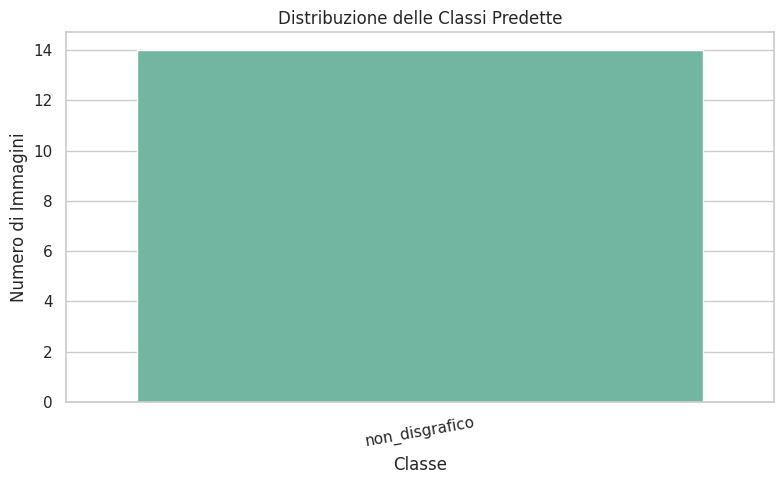

 Grafico a barre salvato in: /content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/test_images/grafico_barre_predizioni.png


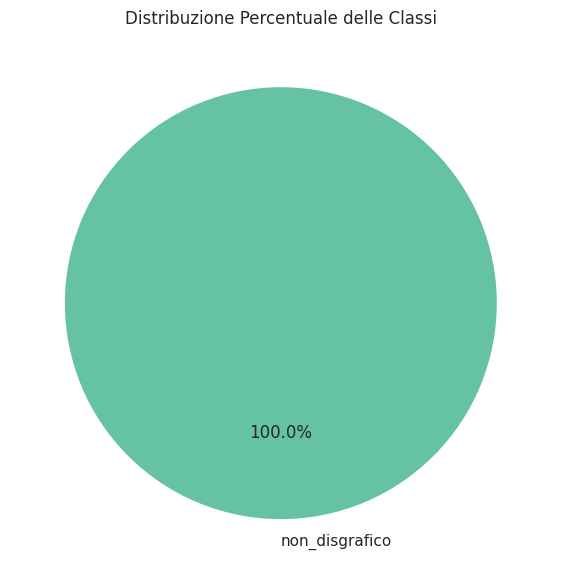

 Grafico a torta salvato in: /content/drive/MyDrive/2023-DL-progetto-Marchi-Pallotta-Fadale/file/test_images/grafico_torta_predizioni.png


In [ ]:
classify_and_summarize()